In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import math
import sys
import os
sys.path.append('../src') 

from utils.data_loader import load_data

In [3]:

df = pd.read_csv("../data/raw/portfolio_data_2015_2025.csv", header=[0, 1])
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2536 entries, 0 to 2535
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Ticker, Price)  2536 non-null   object 
 1   (TSLA, Open)     2535 non-null   float64
 2   (TSLA, High)     2535 non-null   float64
 3   (TSLA, Low)      2535 non-null   float64
 4   (TSLA, Close)    2535 non-null   float64
 5   (TSLA, Volume)   2535 non-null   float64
 6   (BND, Open)      2535 non-null   float64
 7   (BND, High)      2535 non-null   float64
 8   (BND, Low)       2535 non-null   float64
 9   (BND, Close)     2535 non-null   float64
 10  (BND, Volume)    2535 non-null   float64
 11  (SPY, Open)      2535 non-null   float64
 12  (SPY, High)      2535 non-null   float64
 13  (SPY, Low)       2535 non-null   float64
 14  (SPY, Close)     2535 non-null   float64
 15  (SPY, Volume)    2535 non-null   float64
dtypes: float64(15), object(1)
memory usage: 317.1+ KB
None


In [5]:
df.head()

Ticker       TSLA                                                \
        Price       Open       High        Low      Close       Volume   
0        Date        NaN        NaN        NaN        NaN          NaN   
1  2015-07-01  18.073999  18.174667  17.856667  17.943333   31518000.0   
2  2015-07-02  18.680000  18.830000  18.220667  18.667999  107458500.0   
3  2015-07-06  18.591999  18.779333  18.420000  18.648001   61828500.0   
4  2015-07-07  18.333332  18.346666  17.384666  17.858667   91576500.0   

         BND                                                     SPY  \
        Open       High        Low      Close     Volume        Open   
0        NaN        NaN        NaN        NaN        NaN         NaN   
1  60.794183  60.914460  60.764112  60.816734  5399300.0  175.110995   
2  60.937024  61.027236  60.937024  60.967094  1060100.0  175.397596   
3  61.222695  61.222695  61.057308  61.177586  2210700.0  173.458760   
4  61.410611  61.470746  61.237705  61.237705  4183200.0  174.461933   

                                                    
         High         Low       Close       Volume  
0         NaN         NaN         NaN          NaN  
1  175.363889  174.124717  174.917114  135979900.0  
2  175.566188  174.335441  174.756927  104373700.0  
3  175.043542  173.256441  174.259583  117975400.0  
4  175.481925  172.059452  175.355484  173820200.0

In [6]:
df.isna().sum()
df.dropna()


Ticker        TSLA                                                   \
           Price        Open        High         Low       Close       Volume   
1     2015-07-01   18.073999   18.174667   17.856667   17.943333   31518000.0   
2     2015-07-02   18.680000   18.830000   18.220667   18.667999  107458500.0   
3     2015-07-06   18.591999   18.779333   18.420000   18.648001   61828500.0   
4     2015-07-07   18.333332   18.346666   17.384666   17.858667   91576500.0   
5     2015-07-08   17.288000   17.386667   16.954000   16.997334   93316500.0   
...          ...         ...         ...         ...         ...          ...   
2531  2025-07-24  310.000000  310.149994  300.410004  305.299988  156966000.0   
2532  2025-07-25  308.739990  323.630005  308.010010  316.059998  148227000.0   
2533  2025-07-28  318.450012  330.489990  315.690002  325.589996  112673800.0   
2534  2025-07-29  325.549988  326.250000  318.250000  321.200012   87358900.0   
2535  2025-07-30  322.179993  324.450012  311.619995  319.040009   83931900.0   

            BND                                                     SPY  \
           Open       High        Low      Close     Volume        Open   
1     60.794183  60.914460  60.764112  60.816734  5399300.0  175.110995   
2     60.937024  61.027236  60.937024  60.967094  1060100.0  175.397596   
3     61.222695  61.222695  61.057308  61.177586  2210700.0  173.458760   
4     61.410611  61.470746  61.237705  61.237705  4183200.0  174.461933   
5     61.373039  61.463252  61.312898  61.410629  1967800.0  174.006672   
...         ...        ...        ...        ...        ...         ...   
2531  72.599185  72.798528  72.579254  72.698860  6139200.0  634.599976   
2532  72.708822  72.878265  72.688891  72.878265  4845900.0  635.090027   
2533  72.778590  72.808497  72.718791  72.758659  5806600.0  637.479980   
2534  72.838394  73.147367  72.838394  73.137398  7397900.0  638.349976   
2535  72.948036  73.107503  72.888229  72.948036  5554600.0  635.919983   

                                                       
            High         Low       Close       Volume  
1     175.363889  174.124717  174.917114  135979900.0  
2     175.566188  174.335441  174.756927  104373700.0  
3     175.043542  173.256441  174.259583  117975400.0  
4     175.481925  172.059452  175.355484  173820200.0  
5     174.293280  172.177420  172.413452  164020100.0  
...          ...         ...         ...          ...  
2531  636.150024  633.989990  634.419983   71307100.0  
2532  637.580017  634.840027  637.099976   56865400.0  
2533  638.039978  635.539978  636.940002   54917100.0  
2534  638.669983  634.340027  635.260010   60556300.0  
2535  637.679993  631.539978  634.460022   80418900.0  

[2535 rows x 16 columns]

In [13]:
import pandas as pd

# 1. Verify and fix column structure
print("Original columns:", df.columns.tolist()[:5])  # Show first 5 columns

# If columns are tuples (multi-index), keep them. If not, convert:
if not isinstance(df.columns, pd.MultiIndex):
    df.columns = pd.MultiIndex.from_tuples(eval(str(df.columns.tolist())))

# 2. Extract data with proper alignment
tsla_data = pd.DataFrame({
    'Date': df[('Ticker', 'Price')].values,
    'Close': df[('TSLA', 'Close')].values
})

# 3. Remove header row if exists (check if first row contains column names)
if tsla_data.iloc[0, 0] == 'Date' or isinstance(tsla_data.iloc[0, 0], str):
    tsla_data = tsla_data.iloc[1:]

# 4. Convert and clean
tsla_data['Date'] = pd.to_datetime(tsla_data['Date'])
tsla_data = tsla_data.set_index('Date')
tsla_data = tsla_data.dropna()  # Remove any remaining NA rows

# 5. Final verification
print("\nCleaned data:")
print(tsla_data.head())
print(f"\nIndex type: {type(tsla_data.index)}")
print(f"Date range: {tsla_data.index.min()} to {tsla_data.index.max()}")
print(f"Total points: {len(tsla_data)}")



Original columns: [('Ticker', 'Price'), ('TSLA', 'Open'), ('TSLA', 'High'), ('TSLA', 'Low'), ('TSLA', 'Close')]

Cleaned data:
                Close
Date                 
2015-07-01  17.943333
2015-07-02  18.667999
2015-07-06  18.648001
2015-07-07  17.858667
2015-07-08  16.997334

Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Date range: 2015-07-01 00:00:00 to 2025-07-30 00:00:00
Total points: 2535


In [5]:
tsla_data

,Close
Open,
1970-01-01 00:00:00.000000018,17.943333
1970-01-01 00:00:00.000000018,18.667999
1970-01-01 00:00:00.000000018,18.648001
1970-01-01 00:00:00.000000018,17.858667
1970-01-01 00:00:00.000000017,16.997334
...,...
1970-01-01 00:00:00.000000310,305.299988
1970-01-01 00:00:00.000000308,316.059998
1970-01-01 00:00:00.000000318,325.589996


In [11]:
tsla_data.dropna()

,Close
Date,
2015-07-01,17.943333
2015-07-02,18.667999
2015-07-06,18.648001
2015-07-07,17.858667
2015-07-08,16.997334
...,...
2025-07-24,305.299988
2025-07-25,316.059998
2025-07-28,325.589996


In [12]:
print(tsla_data.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2535 entries, 2015-07-01 to 2025-07-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2535 non-null   float64
dtypes: float64(1)
memory usage: 104.1 KB
None



Training points: 2140
Testing points: 395


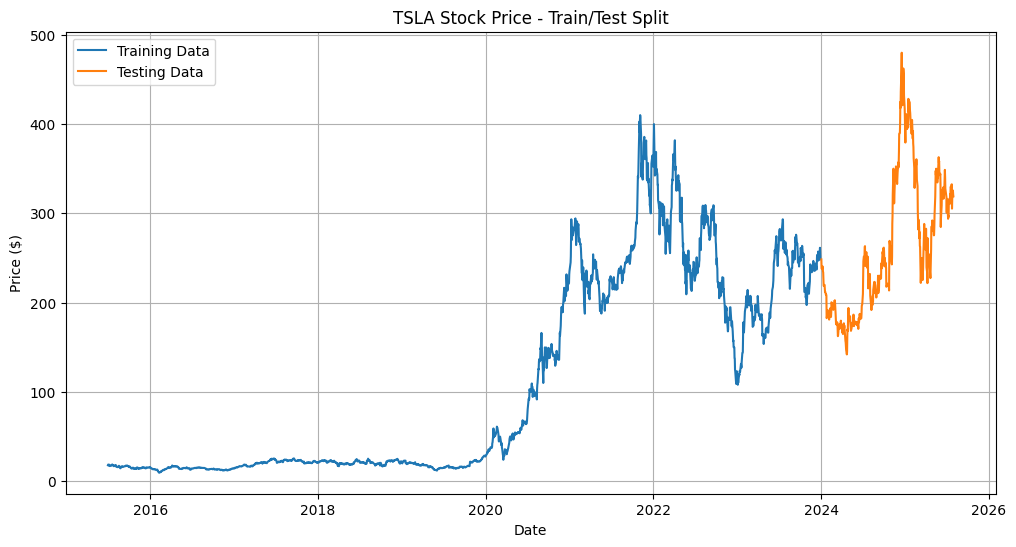

In [14]:
# Chronological split (train: 2015-2023, test: 2024-2025)
train = tsla_data.loc['2015-07-01':'2023-12-31']
test = tsla_data.loc['2024-01-01':]


print(f"\nTraining points: {len(train)}")
print(f"Testing points: {len(test)}")

# Plot the split
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Training Data')
plt.plot(test.index, test['Close'], label='Testing Data')
plt.title('TSLA Stock Price - Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

Data date range:
Start: 2015-07-01 00:00:00
End: 2023-12-29 00:00:00
Number of observations: 2140

Using 40 lags for ACF/PACF analysis


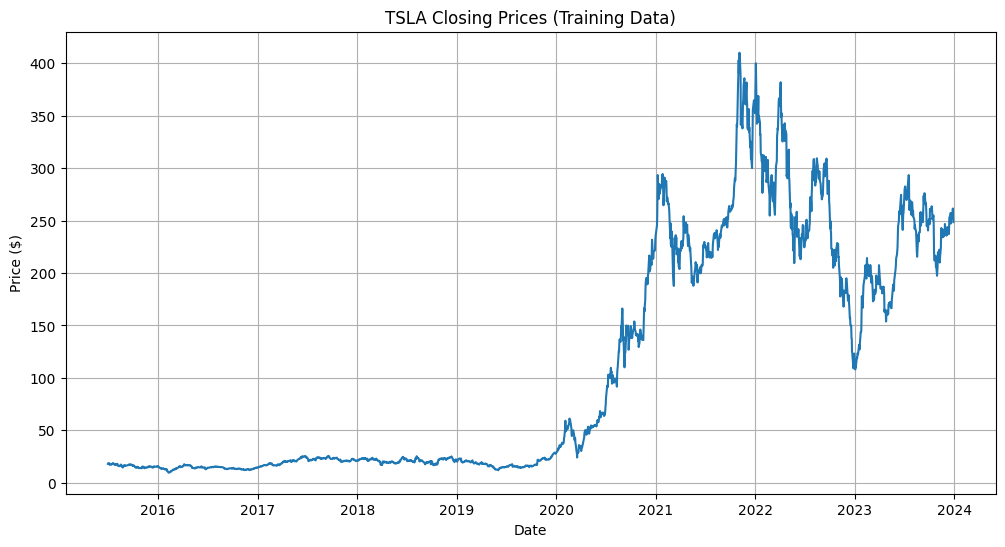

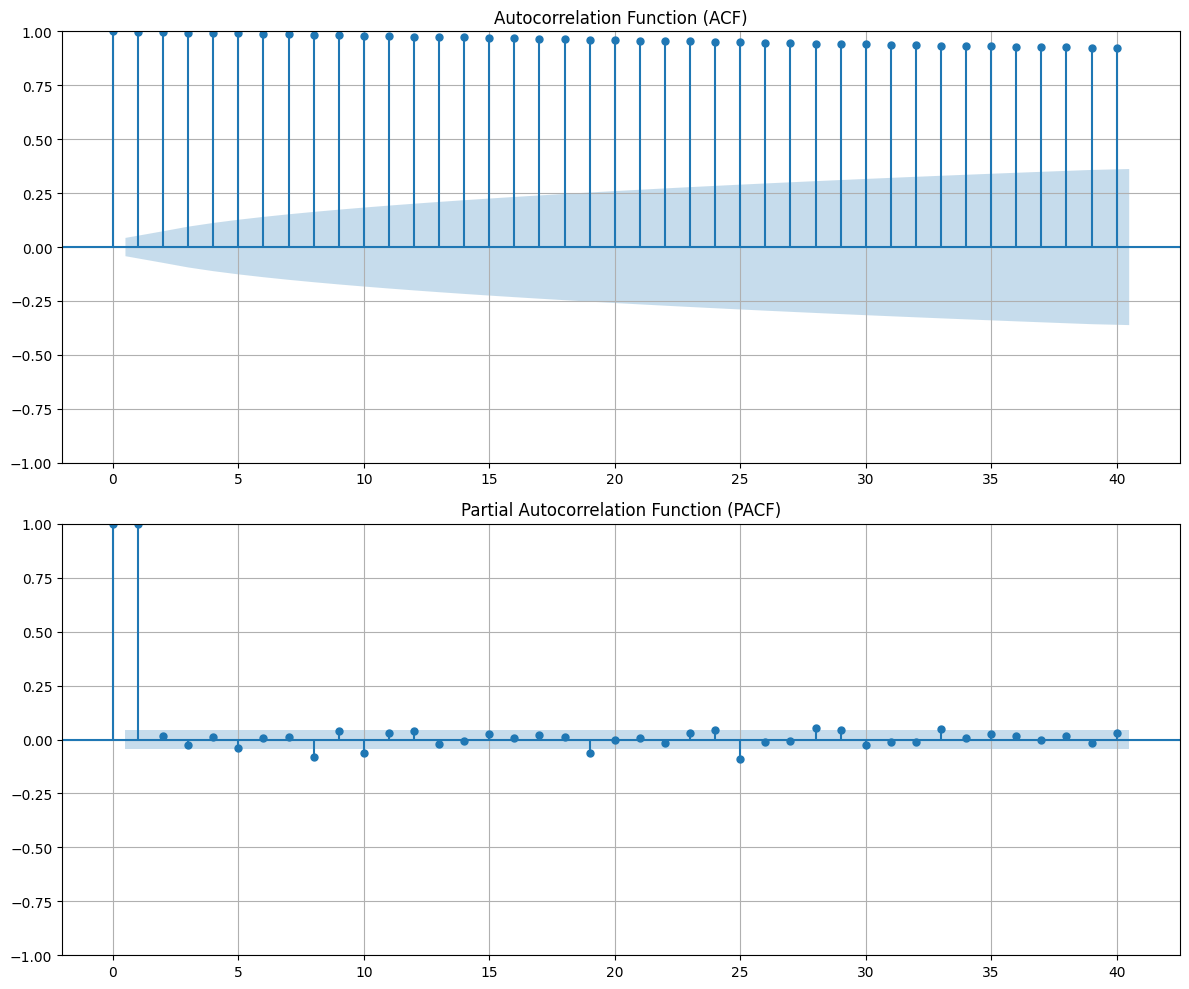


Augmented Dickey-Fuller Test Results:
ADF Statistic: -1.1807058097473089
p-value: 0.6818400342222664
Critical Values:
   1%: -3.433445628558137
   5%: -2.8629075228568746
   10%: -2.5674980038451007

Data is not stationary - applying differencing


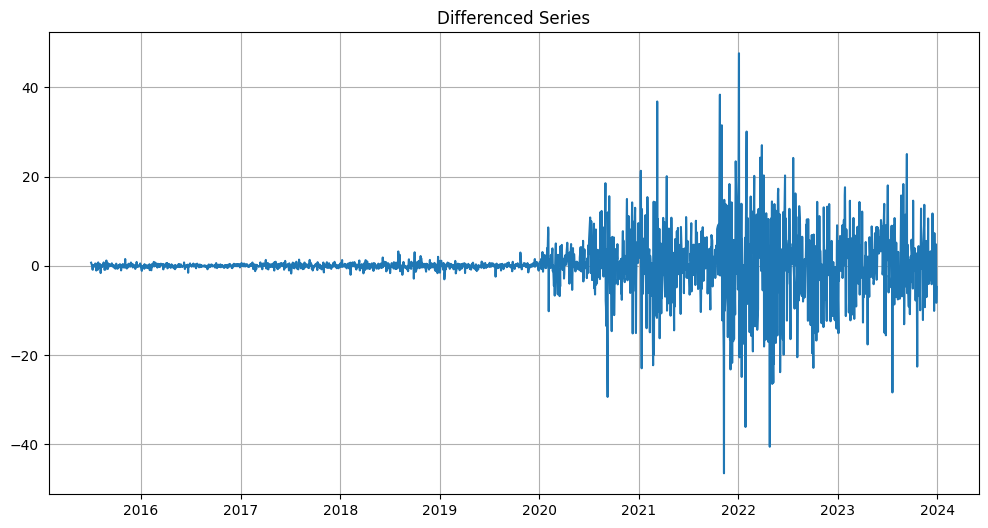


ADF Test on Differenced Data:
ADF Statistic: -8.84007279495988
p-value: 1.6777662068647973e-14


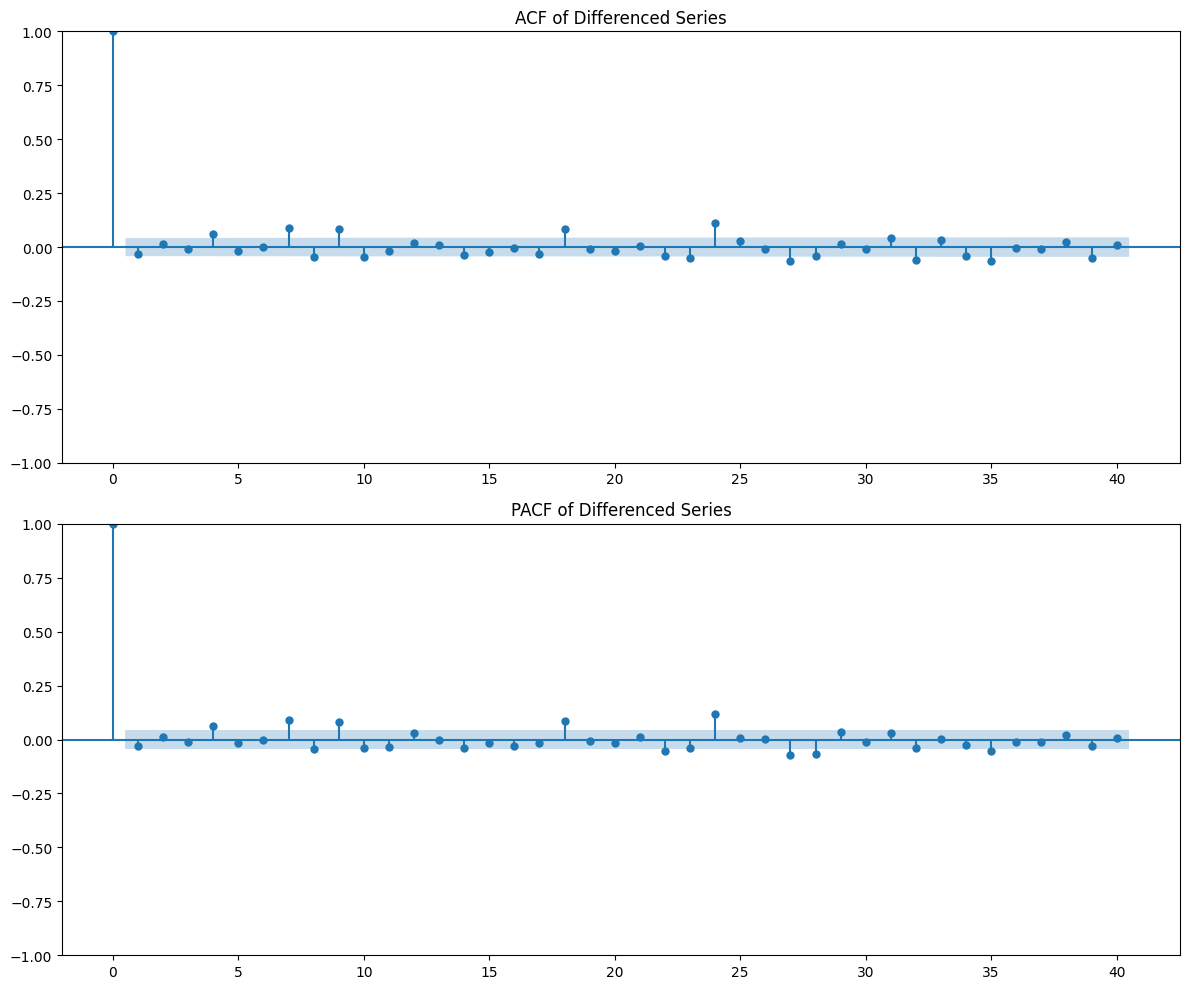


Suggested ARIMA orders based on plots:
Look for where PACF cuts off (p) and ACF cuts off (q)
Differencing order (d) = 1


In [15]:
from statsmodels.tsa.stattools import adfuller

# First, let's verify our data
print("Data date range:")
print(f"Start: {train.index.min()}")
print(f"End: {train.index.max()}")
print(f"Number of observations: {len(train)}")

# Adjust our analysis based on available data
max_lags = min(40, len(train) // 2 - 1)  # Use at most half the data length for lags
print(f"\nUsing {max_lags} lags for ACF/PACF analysis")

# Plot the closing prices to visualize
plt.figure(figsize=(12, 6))
plt.plot(train['Close'])
plt.title('TSLA Closing Prices (Training Data)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

# Plot ACF and PACF with adjusted lags
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# ACF plot
plot_acf(train['Close'], lags=max_lags, ax=ax1, title='Autocorrelation Function (ACF)')
ax1.grid(True)

# PACF plot
plot_pacf(train['Close'], lags=max_lags, ax=ax2, title='Partial Autocorrelation Function (PACF)')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Check stationarity with Augmented Dickey-Fuller test
adf_result = adfuller(train['Close'])
print("\nAugmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# If not stationary (p-value > 0.05), difference the data
if adf_result[1] > 0.05:
    print("\nData is not stationary - applying differencing")
    differenced = train['Close'].diff().dropna()
    
    # Plot differenced series
    plt.figure(figsize=(12, 6))
    plt.plot(differenced)
    plt.title('Differenced Series')
    plt.grid(True)
    plt.show()
    
    # ADF test on differenced data
    adf_diff = adfuller(differenced)
    print("\nADF Test on Differenced Data:")
    print(f"ADF Statistic: {adf_diff[0]}")
    print(f"p-value: {adf_diff[1]}")
    
    # Plot ACF/PACF of differenced data
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    plot_acf(differenced, lags=max_lags, ax=ax1, title='ACF of Differenced Series')
    plot_pacf(differenced, lags=max_lags, ax=ax2, title='PACF of Differenced Series')
    plt.tight_layout()
    plt.show()
    
    # Determine ARIMA orders from differenced series plots
    print("\nSuggested ARIMA orders based on plots:")
    print("Look for where PACF cuts off (p) and ACF cuts off (q)")
    print("Differencing order (d) = 1")
else:
    print("\nData appears stationary - no differencing needed")
    print("Suggested ARIMA orders based on plots:")
    print("Look for where PACF cuts off (p) and ACF cuts off (q)")
    print("Differencing order (d) = 0")

d:\projects\TenAcademy\week11\KAIM-WEEK-11\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\projects\TenAcademy\week11\KAIM-WEEK-11\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\projects\TenAcademy\week11\KAIM-WEEK-11\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2140
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -6825.971
Date:                Tue, 12 Aug 2025   AIC                          13661.943
Time:                        19:22:08   BIC                          13690.285
Sample:                             0   HQIC                         13672.314
                               - 2140                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.0509    133.456      0.810      0.418    -153.519     369.621
ar.L1          0.4012      0.206      1.947      0.052      -0.003       0.805
ar.L2          0.5968      0.206      2.901      0.0

<Figure size 1200x600 with 0 Axes>

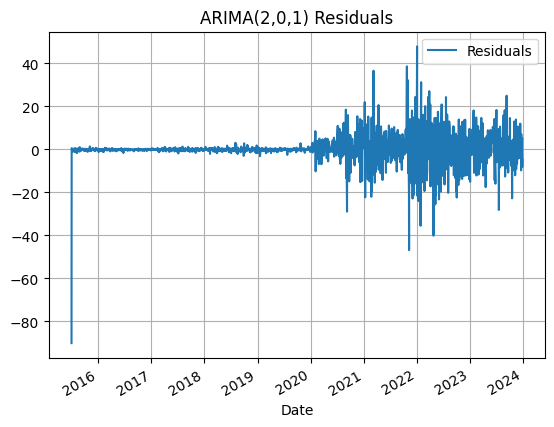

<Figure size 1200x600 with 0 Axes>

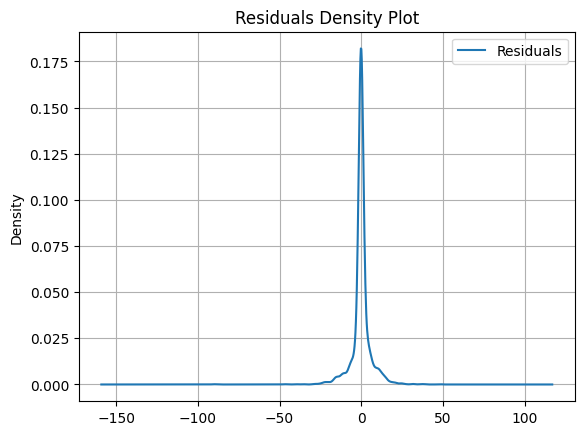

<Figure size 800x800 with 0 Axes>

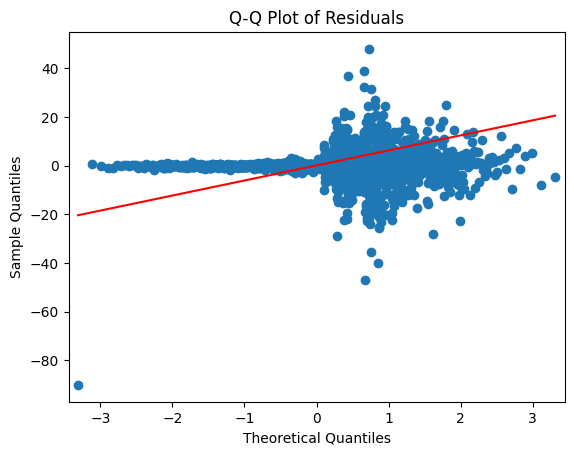


Performing Ljung-Box test with 10 lags

Ljung-Box Test for Residual Autocorrelation:
      lb_stat  lb_pvalue
1    0.016794   0.896888
2    0.051784   0.974440
3    0.078615   0.994274
4    6.001220   0.199057
5    6.435512   0.266117
6    6.436423   0.376116
7   19.624598   0.006440
8   22.382926   0.004254
9   33.690657   0.000101
10  36.750876   0.000062


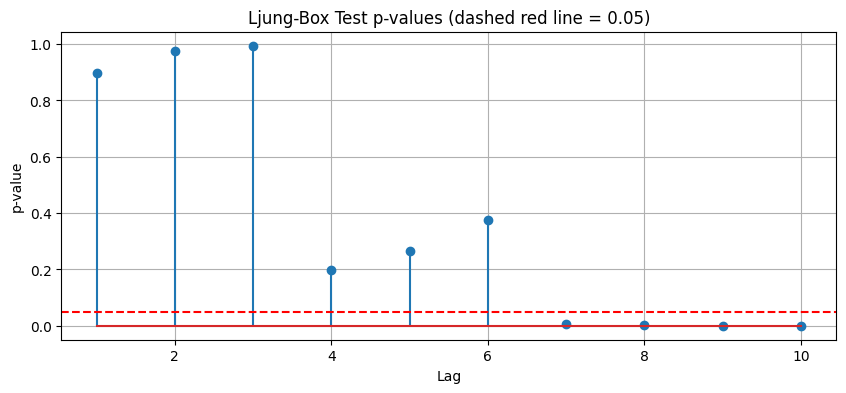

In [16]:
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox

# Fit ARIMA(2,0,1) model
arima_order = (2, 0, 1)
arima_model = ARIMA(train['Close'], order=arima_order)
arima_fit = arima_model.fit()

print(arima_fit.summary())

# Check residuals
residuals = pd.DataFrame(arima_fit.resid)
residuals.columns = ['Residuals']

# Plot residuals
plt.figure(figsize=(12, 6))
residuals.plot(title='ARIMA(2,0,1) Residuals')
plt.grid(True)
plt.show()

# Residuals diagnostics
plt.figure(figsize=(12, 6))
residuals.plot(kind='kde', title='Residuals Density Plot')
plt.grid(True)
plt.show()

# Q-Q plot of residuals
plt.figure(figsize=(8, 8))
qqplot(residuals.dropna(), line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Corrected Ljung-Box test
# Calculate appropriate maximum lag (rule of thumb: min(10, n/5))
max_lag = min(10, len(residuals)//5)
print(f"\nPerforming Ljung-Box test with {max_lag} lags")

if max_lag > 0:
    lb_test = acorr_ljungbox(residuals.dropna(), lags=range(1, max_lag+1), return_df=True)
    print("\nLjung-Box Test for Residual Autocorrelation:")
    print(lb_test)
    
    # Plot p-values
    plt.figure(figsize=(10, 4))
    plt.stem(lb_test.index, lb_test['lb_pvalue'])
    plt.axhline(y=0.05, color='r', linestyle='--')
    plt.title('Ljung-Box Test p-values (dashed red line = 0.05)')
    plt.xlabel('Lag')
    plt.ylabel('p-value')
    plt.grid(True)
    plt.show()
else:
    print("Not enough data for meaningful Ljung-Box test")

Forecasting with ARIMA(2,0,1)

d:\projects\TenAcademy\week11\KAIM-WEEK-11\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\projects\TenAcademy\week11\KAIM-WEEK-11\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


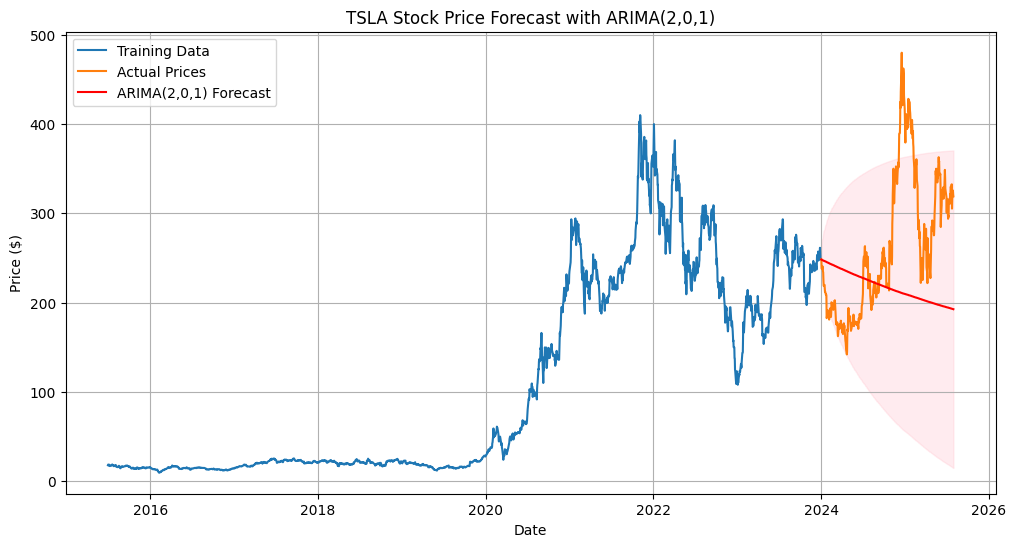


ARIMA(2,0,1) Model Evaluation:
MAE: 78.73
RMSE: 98.95
MAPE: nan%


C:\Users\user\AppData\Local\Temp\ipykernel_15864\3022014617.py:25: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  arima_mape = np.mean(np.abs((test['Close'] - forecast_values) / test['Close'])) * 100


In [17]:
# Forecast on test set
forecast = arima_fit.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Training Data')
plt.plot(test.index, test['Close'], label='Actual Prices')
plt.plot(test.index, forecast_values, label='ARIMA(2,0,1) Forecast', color='red')
plt.fill_between(test.index,
                confidence_intervals.iloc[:, 0],
                confidence_intervals.iloc[:, 1],
                color='pink', alpha=0.3)
plt.title('TSLA Stock Price Forecast with ARIMA(2,0,1)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate evaluation metrics
arima_mae = mean_absolute_error(test['Close'], forecast_values)
arima_rmse = math.sqrt(mean_squared_error(test['Close'], forecast_values))
arima_mape = np.mean(np.abs((test['Close'] - forecast_values) / test['Close'])) * 100

print("\nARIMA(2,0,1) Model Evaluation:")
print(f"MAE: {arima_mae:.2f}")
print(f"RMSE: {arima_rmse:.2f}")
print(f"MAPE: {arima_mape:.2f}%")

LSTM Model Implementation (Comparison)

 Data Preprocessing for LSTM

In [20]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[['Close']])
scaled_test = scaler.transform(test[['Close']])
# Re-examining the data shapes first
print(f"Training data shape: {scaled_train.shape}")
print(f"Test data shape: {scaled_test.shape}")

# Modified create_sequences function with validation
def create_sequences(data, seq_length):
    X, y = [], []
    available_length = len(data) - seq_length
    if available_length <= 0:
        raise ValueError(f"Not enough data for sequence length {seq_length}. Need at least {seq_length+1} samples, but only have {len(data)}")
    
    for i in range(available_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Adjust sequence length if needed
seq_length = 30
required_min_length = seq_length + 1  # Need seq_length+1 points to make one sequence

if len(scaled_train) < required_min_length:
    print(f"Warning: Not enough training data ({len(scaled_train)} points) for seq_length={seq_length}")
    seq_length = min(seq_length, len(scaled_train)-1)
    print(f"Reducing sequence length to {seq_length}")

# Create sequences with the adjusted length
try:
    X_train, y_train = create_sequences(scaled_train, seq_length)
    X_test, y_test = create_sequences(scaled_test, seq_length)
    
    print(f"\nShapes after sequence creation:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    # Reshape only if necessary (should already be 3D)
    if len(X_train.shape) == 2:
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    print(f"\nFinal shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

except ValueError as e:
    print(f"Error: {e}")
    print("Cannot proceed with LSTM - not enough training data")

Training data shape: (2140, 1)
Test data shape: (395, 1)

Shapes after sequence creation:
X_train: (2110, 30, 1), y_train: (2110, 1)
X_test: (365, 30, 1), y_test: (365, 1)

Final shapes:
X_train: (2110, 30, 1), y_train: (2110, 1)
X_test: (365, 30, 1), y_test: (365, 1)


Build LSTM Model

d:\projects\TenAcademy\week11\KAIM-WEEK-11\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0101 - val_loss: 0.0047
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.1905e-04 - val_loss: 0.0029
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.0899e-04 - val_loss: 0.0030
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.6451e-04 - val_loss: 0.0026
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.0826e-04 - val_loss: 0.0028
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.4156e-04 - val_loss: 0.0030
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.1220e-04 - val_loss: 0.0027
Epoch 11/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.9462e-04 - val_loss: 0.0032
Epoch 12/100
66/66 ━━━━━

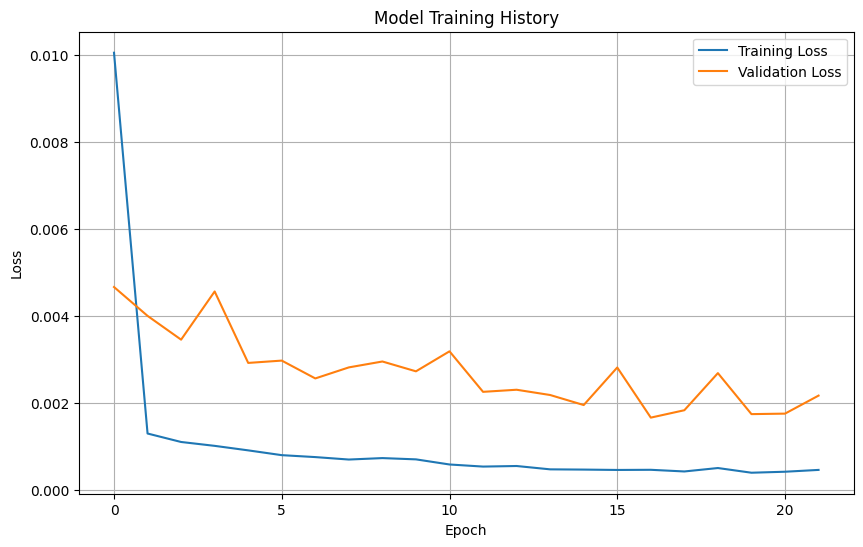

In [21]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train with early stopping
history = lstm_model.fit(X_train, y_train,
                        epochs=100,
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
                        verbose=1)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

Forecast with LSTM

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Pred dates length: 365
Predictions length: 365


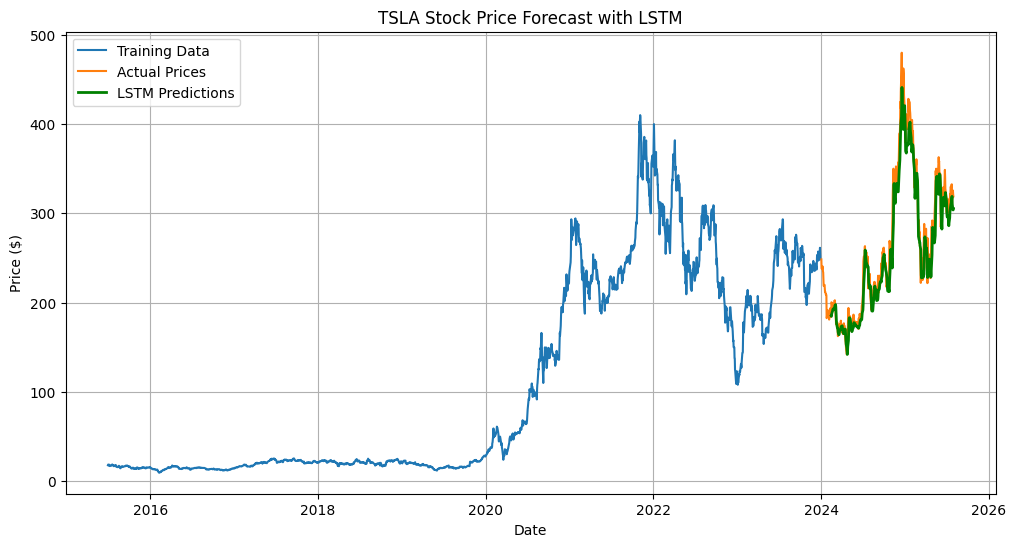

In [23]:
# 1. Prepare test data
scaled_test = scaler.transform(test)
X_test, y_test = create_sequences(scaled_test, seq_length)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 2. Make predictions
scaled_preds = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(scaled_preds)

# 3. Align dates with predictions
# First method (recommended):
pred_dates = test.index[seq_length:]  # Changed from seq_length+1 to seq_length

# Alternative method if still mismatched:
# pred_dates = test.index[-len(lstm_predictions):]

# 4. Verify alignment
print(f"Pred dates length: {len(pred_dates)}")
print(f"Predictions length: {len(lstm_predictions)}")

# 5. Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Training Data')
plt.plot(test.index, test['Close'], label='Actual Prices')
plt.plot(pred_dates, lstm_predictions, 
         label='LSTM Predictions', 
         color='green',
         linewidth=2)
plt.title('TSLA Stock Price Forecast with LSTM')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

Evaluate LSTM Model

Test values shape: (365,)
Predictions shape: (365,)

LSTM Model Evaluation:
MAE: $13.66
RMSE: $18.69
MAPE: 4.89%


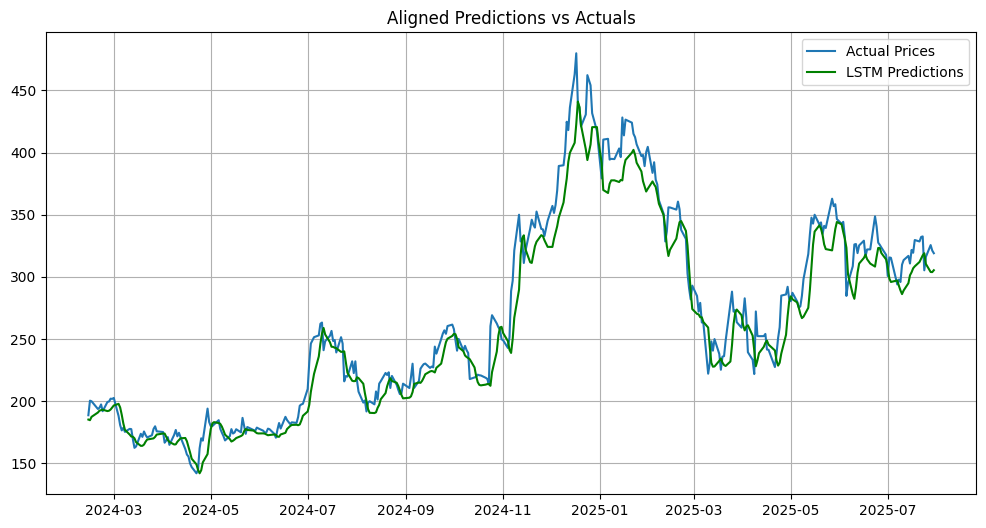

In [25]:
# 1. First ensure perfect alignment
test_points = len(test) - seq_length  # Number of points we can actually predict
actual_test_values = test['Close'].values[-test_points:]  # Last n points
predicted_values = lstm_predictions.flatten()[:test_points]  # First n predictions

# 2. Verify alignment
print(f"Test values shape: {actual_test_values.shape}")
print(f"Predictions shape: {predicted_values.shape}")
assert len(actual_test_values) == len(predicted_values), "Alignment failed!"

# 3. Calculate metrics
lstm_mae = mean_absolute_error(actual_test_values, predicted_values)
lstm_rmse = math.sqrt(mean_squared_error(actual_test_values, predicted_values))
lstm_mape = np.mean(np.abs((actual_test_values - predicted_values) / 
                   actual_test_values)) * 100

# 4. Print results
print("\nLSTM Model Evaluation:")
print(f"MAE: ${lstm_mae:.2f}")
print(f"RMSE: ${lstm_rmse:.2f}")
print(f"MAPE: {lstm_mape:.2f}%")

# 5. Visual confirmation
plt.figure(figsize=(12, 6))
plt.plot(test.index[-test_points:], actual_test_values, label='Actual Prices')
plt.plot(test.index[-test_points:], predicted_values, label='LSTM Predictions', color='green')
plt.title('Aligned Predictions vs Actuals')
plt.legend()
plt.grid(True)
plt.show()

Model Comparision

Model Performance Comparison:
     Metric      ARIMA       LSTM
0       MAE  78.730076  13.663758
1      RMSE  98.947670  18.686043
2  MAPE (%)        NaN   4.887928


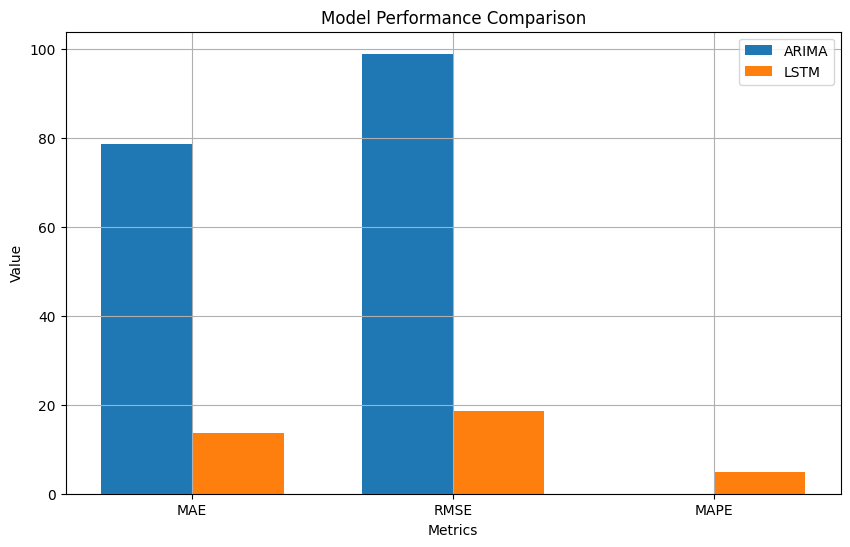

In [26]:
# Create comparison table
comparison = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE (%)'],
    'ARIMA': [arima_mae, arima_rmse, arima_mape],
    'LSTM': [lstm_mae, lstm_rmse, lstm_mape]
})

print("Model Performance Comparison:")
print(comparison)

# Visual comparison
plt.figure(figsize=(10, 6))
metrics = ['MAE', 'RMSE', 'MAPE']
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, comparison['ARIMA'][:3], width, label='ARIMA')
plt.bar(x + width/2, comparison['LSTM'][:3], width, label='LSTM')

plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True)
plt.show()

Save best model

In [27]:
from tensorflow.keras.models import save_model
import joblib
import pickle

# Save LSTM model
save_model(lstm_model, '../models/best_lstm_model.keras')  # .keras or .h5 format

# Save the scaler
joblib.dump(scaler, '../models/scaler.pkl') 

# Save metadata
model_metadata = {
    'seq_length': seq_length,
    'train_range': (train.index.min(), train.index.max()),
    'test_range': (test.index.min(), test.index.max()),
    'metrics': {
        'MAE': lstm_mae,
        'RMSE': lstm_rmse,
        'MAPE': lstm_mape
    }
}

with open('../models/model_metadata.pkl', 'wb') as f:
    pickle.dump(model_metadata, f)